170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Gen Loss: 2.172487735748291, Disc Loss: 0.3425244688987732
Epoch 2, Gen Loss: 2.002507448196411, Disc Loss: 0.44758737087249756
Epoch 3, Gen Loss: 1.1452080011367798, Disc Loss: 0.7637839913368225
Epoch 4, Gen Loss: 1.662942886352539, Disc Loss: 0.7591477632522583
Epoch 5, Gen Loss: 1.7417806386947632, Disc Loss: 1.2814944982528687
Epoch 6, Gen Loss: 2.038938283920288, Disc Loss: 0.6785013675689697
Epoch 7, Gen Loss: 1.6001265048980713, Disc Loss: 0.8362971544265747
Epoch 8, Gen Loss: 2.83158016204834, Disc Loss: 0.8044643402099609
Epoch 9, Gen Loss: 2.243842363357544, Disc Loss: 0.37330421805381775
Epoch 10, Gen Loss: 0.8642004728317261, Disc Loss: 1.2094042301177979
Epoch 11, Gen Loss: 1.8172731399536133, Disc Loss: 0.5846771001815796
Epoch 12, Gen Loss: 1.804614543914795, Disc Loss: 0.7493802309036255
Epoch 13, Gen Loss: 1.737215280532837, Disc Loss: 1.3970524072647095
Epoch 14, Gen Loss: 1.5241551399230957, Disc Loss: 1.875913381576538
Epoch 15, Gen Loss: 1.444912672042846

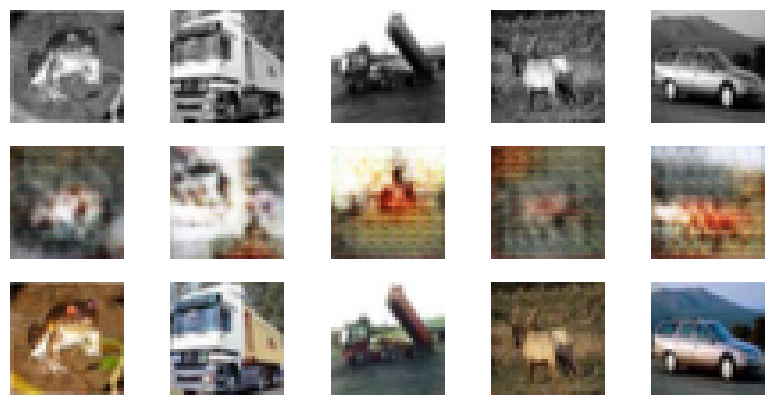

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Build Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(32, 32, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Loss Functions
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Models
generator = build_generator()
discriminator = build_discriminator()

# Training Step
@tf.function
def train_step(real_images, gray_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(gray_images, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training Function
def train(dataset, epochs):
    for epoch in range(epochs):
        for real_images, gray_images in dataset:
            gen_loss, disc_loss = train_step(real_images, gray_images)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

# Dataset Preparation
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 127.5 - 1
x_train_gray = tf.image.rgb_to_grayscale(x_train)

BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train_gray))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Train the Model
EPOCHS = 15
train(dataset, EPOCHS)

# Visualization
def generate_and_show(generator, gray_images, real_images):
    generated_images = generator(gray_images, training=False)
    plt.figure(figsize=(10, 5))
    for i in range(5):
        # Grayscale input
        plt.subplot(3, 5, i+1)
        plt.imshow(tf.squeeze(gray_images[i]) * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

        # Generated image
        plt.subplot(3, 5, i+6)
        plt.imshow((generated_images[i] * 0.5 + 0.5).numpy())
        plt.axis('off')

        # Real image
        plt.subplot(3, 5, i+11)
        plt.imshow((real_images[i] * 0.5 + 0.5).numpy())
        plt.axis('off')
    plt.show()

# Take a sample of grayscale and real images
sample_gray = tf.expand_dims(x_train_gray[:5], axis=-1)  # Ensure shape is (batch_size, 32, 32, 1)
sample_real = x_train[:5]  # Shape (batch_size, 32, 32, 3)

# Convert to float32 and ensure normalization
sample_gray = tf.convert_to_tensor(sample_gray, dtype=tf.float32)
sample_real = tf.convert_to_tensor(sample_real, dtype=tf.float32)

# Generate and show images
generate_and_show(generator, sample_gray, sample_real)
